In [2]:
# %% [markdown]
# # NFL Play Predictor - Training Pipeline
# Trains a Stochastic Gradient Descent (SGD) classifier to predict play calls.
# ## Run the entire notebook once to generate a joblib file for inference use.

# %%
import sys
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Add 'src' to python path to allow importing custom modules
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from nfl_utils import load_and_clean_data, get_features_and_target, PLAY_TYPE_MAPPING

# %%
# Load Data
DATA_PATH = '../data/raw/NFL_PBP_combined_playground_csv_no2020.csv'
df = load_and_clean_data(DATA_PATH)

Loading data from ../data/raw/NFL_PBP_combined_playground_csv_no2020.csv...


c:\Users\lbsch\OneDrive\Documents\GitHub\nfl_play_predictor\src\nfl_utils.py:29: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Data cleaned. Rows remaining: 398197


In [3]:
# Prepare Features
X, y = get_features_and_target(df)

# Train/Test Split (Stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# %% [markdown]
# ## Model Pipeline
# We use a Pipeline to bundle the Scaler and the Classifier. This prevents data leakage.

# %%
clf_pipeline = make_pipeline(
    StandardScaler(),
    SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)
)

In [4]:
print("Training model...")
clf_pipeline.fit(X_train, y_train)
print("Training complete.")

Training model...
Training complete.


Classification Report:
              precision    recall  f1-score   support

        Rush       0.49      0.07      0.13     24539
        Pass       0.49      0.91      0.63     34605
     Special       0.64      0.24      0.35      6013
     No Play       0.71      0.43      0.54     14483

    accuracy                           0.51     79640
   macro avg       0.58      0.41      0.41     79640
weighted avg       0.54      0.51      0.44     79640



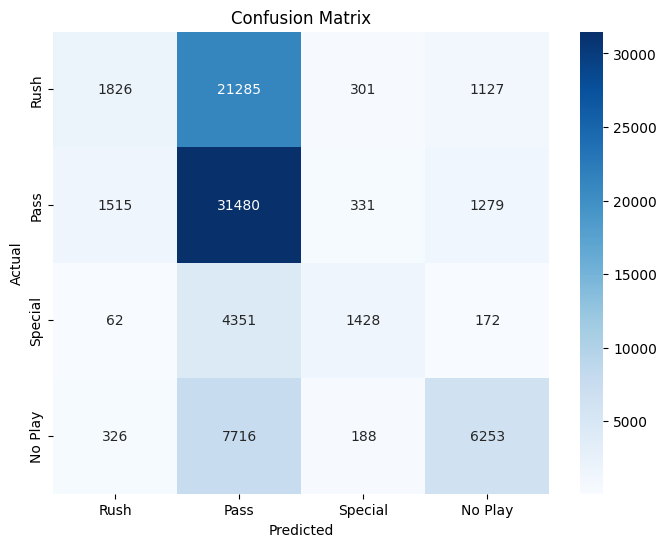

In [5]:
# %% [markdown]
# ## Evaluation

# %%
y_pred = clf_pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[PLAY_TYPE_MAPPING[i] for i in sorted(PLAY_TYPE_MAPPING.keys())]))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=PLAY_TYPE_MAPPING.values(),
            yticklabels=PLAY_TYPE_MAPPING.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [6]:
# %% [markdown]
# ## Save Model
# Serialize the pipeline for the inference application.

model_dir = '../data/models'
os.makedirs(model_dir, exist_ok=True)
save_path = os.path.join(model_dir, 'nfl_sgd_pipeline.joblib')

joblib.dump(clf_pipeline, save_path)
print(f"Model saved to {save_path}")

Model saved to ../data/models\nfl_sgd_pipeline.joblib


In [7]:
# Train and compare with XGBoost Classifier
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder


In [8]:
# Encode full target vector
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split X and newly encoded y
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [9]:
# Define XGBoost pipeline
clf_pipeline = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    objective='multi:softprob', # Probabilities for multi-class
    eval_metric='mlogloss',     # Standard metric for multi-class
    random_state=42,
    n_jobs=-1
)

In [10]:
print("Training XGBoost Model...")
# Now we use y_train (the encoded split), NOT y_encoded (the full list)
clf_pipeline.fit(X_train, y_train) 
print("Training Complete.")

Training XGBoost Model...
Training Complete.


Classification Report:
              precision    recall  f1-score   support

        Rush       0.56      0.46      0.50     24539
        Pass       0.55      0.76      0.64     34605
     Special       0.87      0.77      0.81      6013
     No Play       0.96      0.41      0.57     14483

    accuracy                           0.60     79640
   macro avg       0.73      0.60      0.63     79640
weighted avg       0.65      0.60      0.60     79640



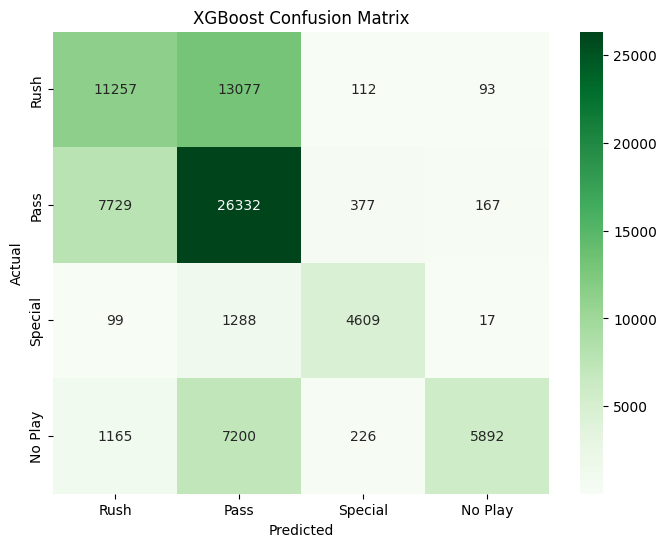

In [11]:
# Define the mapping locally (or import it from src.nfl_utils)
PLAY_TYPE_MAPPING = {
    1: "Rush",
    2: "Pass",
    3: "Special",
    4: "No Play"
}

# Convert the encoder's float classes (1.0, 2.0) into readable strings
# We cast to int first (1.0 -> 1) to match our dictionary keys
class_names = [PLAY_TYPE_MAPPING.get(int(c), str(c)) for c in le.classes_]

# Predict
y_pred = clf_pipeline.predict(X_test)

# Print Report with String Names
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)   
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [12]:
# ## Save Model
# Serialize the pipeline for the inference application.

model_dir = '../data/models'
os.makedirs(model_dir, exist_ok=True)
save_path = os.path.join(model_dir, 'nfl_xgb_pipeline.joblib')

joblib.dump(clf_pipeline, save_path)
print(f"Model saved to {save_path}")

Model saved to ../data/models\nfl_xgb_pipeline.joblib
